# Loading Data

In [192]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.metrics import accuracy_score

# install fairlearn
!pip install fairlearn

# import fairlearn
import fairlearn
from fairlearn.metrics import demographic_parity_ratio, MetricFrame, selection_rate, false_positive_rate, false_negative_rate
from fairlearn.reductions import DemographicParity, ErrorRate, EqualizedOdds, ExponentiatedGradient
from fairlearn.adversarial import AdversarialFairnessClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


In [193]:
# Read in CSV
df = pd.read_csv('nyc_domestic_violence_report.csv')

#save copy of orgianl data
df_original = df.copy()

<ipython-input-193-4fc540f2f6ba>:2: DtypeWarning: Columns (5,6,8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('nyc_domestic_violence_report.csv')


In [194]:
df

,Offense Type,Report Date,Incident Precinct Code,Borough Name,Intimate Relationship Flag,Victim Race,Victim Sex,Victim Reported Age,Suspect Race,Suspect Sex,Suspect Reported Age,COMMDIST,Poverty,Median Income,Unemployment
0,DIR,12/23/2020,5,MANHATTAN,MISSING,WHITE,FEMALE,NaN,OTHER,NaN,NaN,103.0,1.0,1.0,NaN
1,DIR,01/08/2020,7,MANHATTAN,YES,WHITE,MALE,NaN,WHITE,FEMALE,NaN,103.0,1.0,1.0,NaN
2,DIR,04/05/2020,5,MANHATTAN,MISSING,WHITE,MALE,NaN,WHITE,NaN,NaN,103.0,1.0,1.0,NaN
3,DIR,01/01/2021,10,MANHATTAN,NO,WHITE,NaN,NaN,WHITE,NaN,NaN,104.0,NaN,NaN,NaN
4,DIR,01/10/2021,10,MANHATTAN,NO,WHITE,FEMALE,NaN,OTHER,MALE,NaN,104.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
483785,DIR,04/30/2021,109,QUEENS,MISSING,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
483786,DIR,10/30/2020,42,BRONX,MISSING,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
483787,DIR,11/07/2020,42,BRONX,MISSING,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
483788,DIR,12/04/2020,47,BRONX,MISSING,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Cleaning Data

In [195]:
#select only reports of Intimate partner violence

#Clean 'Intimate Relationship Flag' column
np.unique(df['Intimate Relationship Flag'])
df['Intimate Relationship Flag'] = df['Intimate Relationship Flag'].str.title()

#determin length of remaining data.
df_IPV = df.groupby(by='Intimate Relationship Flag').get_group('Yes')
len(df_IPV)

231043

In [196]:
#Check for data type consistancy
df_IPV.info()

<class 'pandas.core.frame.DataFrame'>
Index: 231043 entries, 1 to 442120
Data columns (total 15 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Offense Type                231043 non-null  object 
 1   Report Date                 231043 non-null  object 
 2   Incident Precinct Code      231043 non-null  int64  
 3   Borough Name                231043 non-null  object 
 4   Intimate Relationship Flag  231043 non-null  object 
 5   Victim Race                 223456 non-null  object 
 6   Victim Sex                  226876 non-null  object 
 7   Victim Reported Age         206141 non-null  float64
 8   Suspect Race                218345 non-null  object 
 9   Suspect Sex                 223052 non-null  object 
 10  Suspect Reported Age        185295 non-null  float64
 11  COMMDIST                    231005 non-null  float64
 12  Poverty                     90734 non-null   float64
 13  Median Income      

In [197]:
# count null values is data set
df_IPV.isnull().sum()

,0
Offense Type,0
Report Date,0
Incident Precinct Code,0
Borough Name,0
Intimate Relationship Flag,0
Victim Race,7587
Victim Sex,4167
Victim Reported Age,24902
Suspect Race,12698
Suspect Sex,7991


In [198]:


#may have an issue?
# A value is trying to be set on a copy of a slice from a DataFrame.
#Try using .loc[row_indexer,col_indexer] = value instead

In [199]:
#clean IPV data, changing NAN values.

#changing NaNs in columns: Poverty, Median Income, and Unemployment to value 0
df_IPV['Poverty'] = df_IPV['Poverty'].fillna(0)
df_IPV['Median Income'] = df_IPV['Median Income'].fillna(0)
df_IPV['Unemployment'] = df_IPV['Unemployment'].fillna(0)

#remove certainly incorect age 1017.
df_IPV = df_IPV.drop(df_IPV[df_IPV['Suspect Reported Age'] == 1017].index)

#Replace NAN value in Age columns with adverage age.
df_IPV['Victim Reported Age'] = df_IPV['Victim Reported Age'].fillna( df_IPV['Victim Reported Age'].mean())
df_IPV['Suspect Reported Age'] = df_IPV['Suspect Reported Age'].fillna( df_IPV['Suspect Reported Age'].mean())

#change ages to integers
df_IPV['Victim Reported Age'] = df_IPV['Victim Reported Age'].astype(int)
df_IPV['Suspect Reported Age'] = df_IPV['Suspect Reported Age'].astype(int)

#Drop remain rows containg NAN using .dropna()
clean_df = df_IPV.dropna()

#change Sex to binary form, 0=female 1=male
clean_df['Suspect Sex'] = clean_df['Suspect Sex'].replace('MALE', 1).replace('FEMALE', 0)
clean_df = clean_df.drop(clean_df[clean_df['Suspect Sex'] == 'UNKNWN'].index)
clean_df['Victim Sex'] = clean_df['Victim Sex'].replace('MALE', 1).replace('FEMALE', 0)
clean_df = clean_df.drop(clean_df[clean_df['Victim Sex'] == 'UNKNWN'].index)

#change Report Date to datetime
clean_df['Report Date'] = pd.to_datetime(clean_df['Report Date'])

<ipython-input-199-fc21e0432c9e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_IPV['Poverty'] = df_IPV['Poverty'].fillna(0)
<ipython-input-199-fc21e0432c9e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_IPV['Median Income'] = df_IPV['Median Income'].fillna(0)
<ipython-input-199-fc21e0432c9e>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.py

In [200]:
#Check data type consitancy
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 215348 entries, 1 to 387792
Data columns (total 15 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   Offense Type                215348 non-null  object        
 1   Report Date                 215348 non-null  datetime64[ns]
 2   Incident Precinct Code      215348 non-null  int64         
 3   Borough Name                215348 non-null  object        
 4   Intimate Relationship Flag  215348 non-null  object        
 5   Victim Race                 215348 non-null  object        
 6   Victim Sex                  215348 non-null  int64         
 7   Victim Reported Age         215348 non-null  int64         
 8   Suspect Race                215348 non-null  object        
 9   Suspect Sex                 215348 non-null  object        
 10  Suspect Reported Age        215348 non-null  int64         
 11  COMMDIST                    215348 non-null 

In [201]:
#Add Binary Column marking the report as a Felony (1) or DIR (0)

def offense(offense_type):
    if offense_type == "RAPE" or offense_type == 'FELONY ASSAULT':
        return 1
    else:
        return 0

clean_df['Felony Offence'] = clean_df['Offense Type'].apply(offense)

# Data Exploration

In [202]:
clean_df

,Offense Type,Report Date,Incident Precinct Code,Borough Name,Intimate Relationship Flag,Victim Race,Victim Sex,Victim Reported Age,Suspect Race,Suspect Sex,Suspect Reported Age,COMMDIST,Poverty,Median Income,Unemployment,Felony Offence
1,DIR,2020-01-08,7,MANHATTAN,Yes,WHITE,1,35,WHITE,0,36,103.0,1.0,1.0,0.0,0
9,DIR,2021-11-03,9,MANHATTAN,Yes,WHITE,0,35,WHITE,1,36,103.0,1.0,1.0,0.0,0
10,DIR,2021-11-05,9,MANHATTAN,Yes,WHITE,0,35,WHITE,1,36,103.0,1.0,1.0,0.0,0
19,FELONY ASSAULT,2020-10-18,47,BRONX,Yes,WHITE HISPANIC,1,5,BLACK,1,36,212.0,0.0,0.0,1.0,1
20,FELONY ASSAULT,2020-10-18,47,BRONX,Yes,WHITE HISPANIC,1,5,WHITE HISPANIC,1,36,212.0,0.0,0.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
387787,DIR,2021-04-29,102,QUEENS,Yes,AMERICAN INDIAN/ALASKAN NATIVE,0,61,BLACK,1,74,409.0,0.0,0.0,0.0,0
387788,DIR,2020-07-04,94,BROOKLYN,Yes,AMERICAN INDIAN/ALASKAN NATIVE,1,77,AMERICAN INDIAN/ALASKAN NATIVE,0,74,301.0,0.0,0.0,0.0,0
387790,DIR,2021-08-09,102,QUEENS,Yes,AMERICAN INDIAN/ALASKAN NATIVE,0,64,AMERICAN INDIAN/ALASKAN NATIVE,1,76,409.0,0.0,0.0,0.0,0
387791,DIR,2021-05-27,83,BROOKLYN,Yes,AMERICAN INDIAN/ALASKAN NATIVE,0,71,AMERICAN INDIAN/ALASKAN NATIVE,1,76,304.0,1.0,1.0,0.0,0


In [203]:
#Create and Disply correlation matrix for all Numerical Entires
num_only_df = clean_df[['Incident Precinct Code', 'Victim Sex', 'Victim Reported Age', 'Suspect Reported Age', 'Suspect Sex', 'COMMDIST', 'Poverty', 'Median Income', 'Unemployment', 'Felony Offence']]
num_only_df.corr()

,Incident Precinct Code,Victim Sex,Victim Reported Age,Suspect Reported Age,Suspect Sex,COMMDIST,Poverty,Median Income,Unemployment,Felony Offence
Incident Precinct Code,1.000000,-0.010560,0.018093,0.026330,-0.014259,0.969815,-0.454149,-0.458596,-0.437522,-0.004722
Victim Sex,-0.010560,1.000000,0.151966,-0.047241,-0.818585,-0.011270,-0.011880,-0.014617,-0.004914,-0.019604
Victim Reported Age,0.018093,0.151966,1.000000,0.694320,-0.137419,0.022302,-0.039390,-0.037074,-0.039797,-0.032463
Suspect Reported Age,0.026330,-0.047241,0.694320,1.000000,0.057538,0.030795,-0.044458,-0.042770,-0.043911,-0.024471
Suspect Sex,-0.014259,-0.818585,-0.137419,0.057538,1.000000,-0.014334,0.026644,0.028000,0.021619,0.019040
COMMDIST,0.969815,-0.011270,0.022302,0.030795,-0.014334,1.000000,-0.462798,-0.452242,-0.463915,-0.004647
Poverty,-0.454149,-0.011880,-0.039390,-0.044458,0.026644,-0.462798,1.000000,0.970849,0.568739,0.004263
Median Income,-0.458596,-0.014617,-0.037074,-0.042770,0.028000,-0.452242,0.970849,1.000000,0.542413,0.003858
Unemployment,-0.437522,-0.004914,-0.039797,-0.043911,0.021619,-0.463915,0.568739,0.542413,1.000000,0.015093
Felony Offence,-0.004722,-0.019604,-0.032463,-0.024471,0.019040,-0.004647,0.004263,0.003858,0.015093,1.000000


In [204]:
# Number of reports of suspects for each race
clean_df['Suspect Race'].value_counts()

,count
Suspect Race,
BLACK,112522
WHITE,63503
OTHER,23762
ASIAN / PACIFIC ISLANDER,10958
WHITE HISPANIC,2738
AMERICAN INDIAN/ALASKAN NATIVE,951
BLACK HISPANIC,914


In [205]:
# Number of reports of Victims for each race
clean_df['Victim Race'].value_counts()

,count
Victim Race,
BLACK,106653
WHITE,72463
OTHER,19858
ASIAN / PACIFIC ISLANDER,11654
WHITE HISPANIC,3101
AMERICAN INDIAN/ALASKAN NATIVE,908
BLACK HISPANIC,711


# Data Visulization

In [206]:
# Create a series with the count of reports for each Race in 'Suspect Race'
clean_df_race_sus = clean_df.groupby(['Suspect Race'])
clean_df_race_sus = clean_df_race_sus['Suspect Race']
clean_df_race_sus = clean_df_race_sus.value_counts()
sorted_race_sus = clean_df_race_sus.sort_values(ascending=False)

In [207]:
# New column with age gap between suspect and victim
clean_df['Suspect-Victim Age Gap'] = clean_df['Suspect Reported Age'] - clean_df['Victim Reported Age']

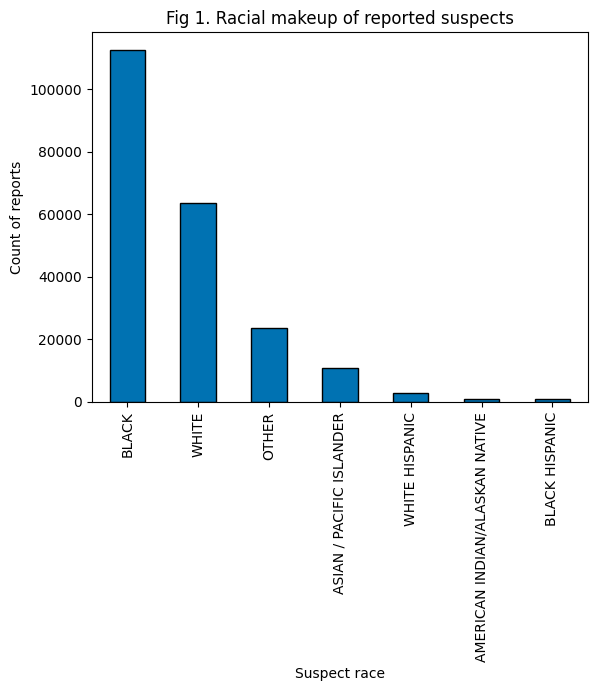

In [208]:
# Bar plot for Suspect race
sorted_race_sus.plot.bar(edgecolor='black')
plt.xticks(rotation=90)
plt.title('Fig 1. Racial makeup of reported suspects')
plt.ylabel('Count of reports')
plt.xlabel('Suspect race')
plt.show()

In [209]:
# Create a series with the counts of reports for each Race in 'Victim Race'
clean_df_race_vic = clean_df.groupby(['Victim Race'])
clean_df_race_vic = clean_df_race_vic['Victim Race']
clean_df_race_vic = clean_df_race_vic.value_counts()
sorted_race_vic = clean_df_race_vic.sort_values(ascending=False)

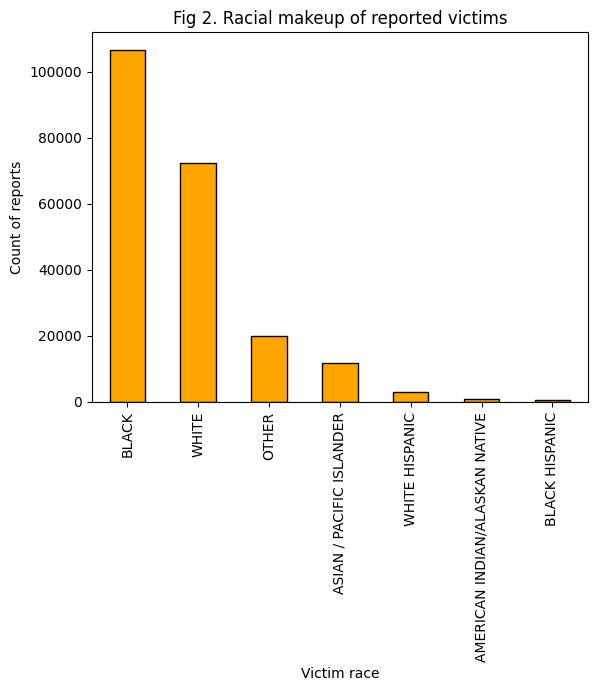

In [210]:
# Bar plot for victim race
sorted_race_vic.plot.bar(color='orange',edgecolor='black')
plt.xticks(rotation=90)
plt.title('Fig 2. Racial makeup of reported victims')
plt.ylabel('Count of reports')
plt.xlabel('Victim race')
plt.show()

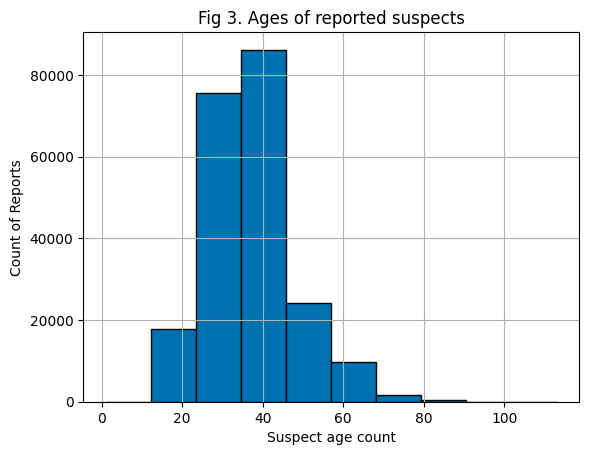

In [211]:
#Suspect Age histogram
clean_df.hist('Suspect Reported Age',edgecolor='black')
plt.title('Fig 3. Ages of reported suspects')
plt.ylabel('Count of Reports')
plt.xlabel('Suspect age count')
plt.show()

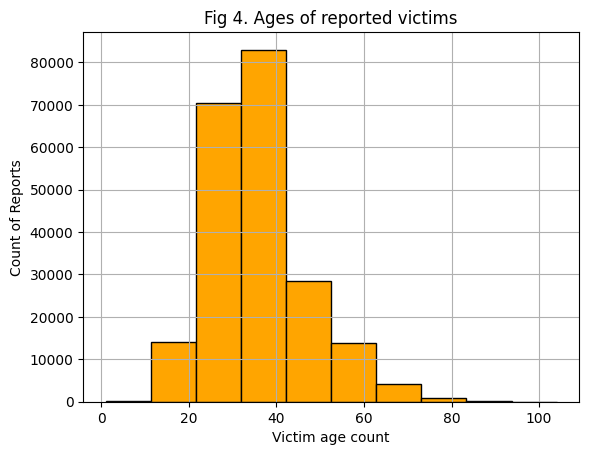

In [212]:
#Victim Age histogram
clean_df.hist('Victim Reported Age', edgecolor='black', color='orange')
plt.title('Fig 4. Ages of reported victims')
plt.ylabel('Count of Reports')
plt.xlabel('Victim age count')
plt.show()

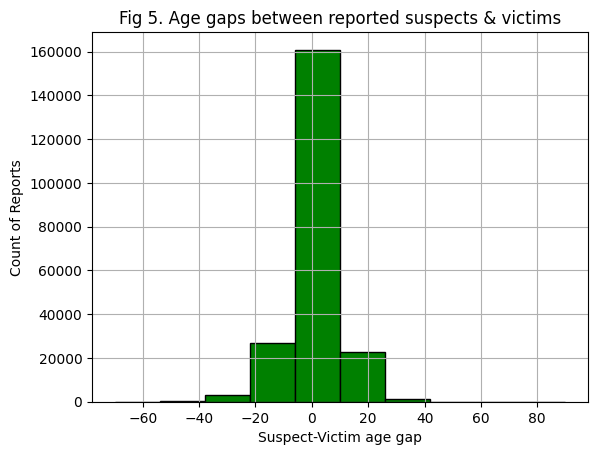

In [213]:
#Suspect-Victim Age Gap histogram
clean_df.hist('Suspect-Victim Age Gap', edgecolor='black', color='green')
plt.title('Fig 5. Age gaps between reported suspects & victims')
plt.ylabel('Count of Reports')
plt.xlabel('Suspect-Victim age gap')
plt.show()

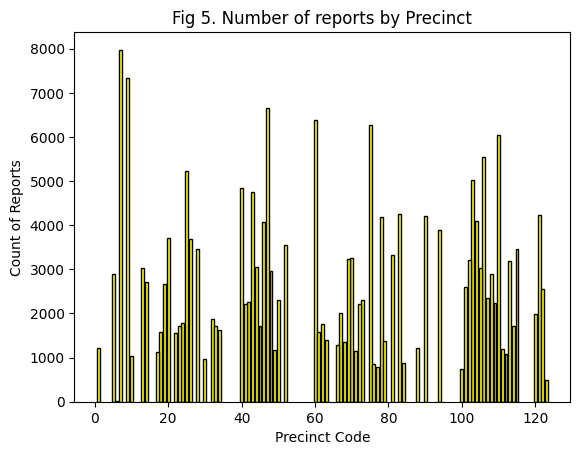

In [214]:
#Number of reports by Precinct Number
plt.bar(clean_df['Incident Precinct Code'].unique(), clean_df['Incident Precinct Code'].value_counts(), color= 'Yellow', edgecolor= 'black')
plt.title('Fig 5. Number of reports by Precinct')
plt.ylabel('Count of Reports')
plt.xlabel('Precinct Code')
plt.show()

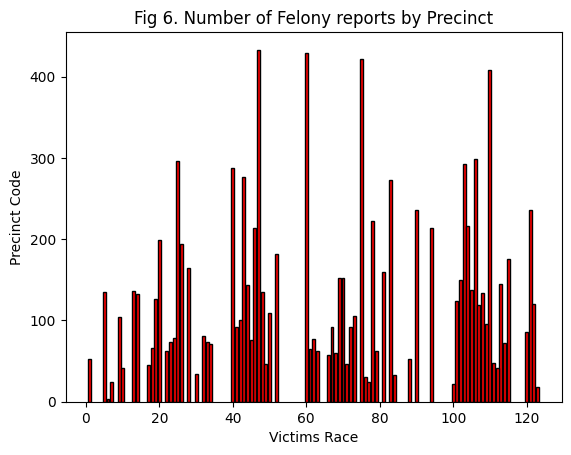

In [215]:
#make DataFrame containing only reports of Felony Offence
felony_df = clean_df[clean_df['Felony Offence'] == True]

#Number of Felony reports by Precinct Number
plt.bar(felony_df['Incident Precinct Code'].unique(), felony_df['Incident Precinct Code'].value_counts(), color= 'Red', edgecolor= 'black')
plt.title('Fig 6. Number of Felony reports by Precinct')
plt.ylabel('Precinct Code')
plt.xlabel('Victims Race')
plt.show()

In [216]:
clean_df.to_csv('cleaned_nyc_domestic_violence_report.csv')

# Report Date Analysis

In [217]:
clean_df['Report Date'].min(), clean_df['Report Date'].max()

(Timestamp('2019-12-05 00:00:00'), Timestamp('2021-12-31 00:00:00'))

In [218]:
#helper, filters dataframe when given df year and month
def dateFiltered(df, year, month):
    newdf = df.loc[df['Report Date'] > datetime.datetime(year=year, month=month, day=1)]
    newdf = newdf.loc[df['Report Date'] < datetime.datetime(year=year, month=(month+1), day=1)]
    return newdf

# helper, gets number of reports when given df and precinct
def getReports(df, precinct):
    precinctdf = df.loc[df['Incident Precinct Code'] == precinct]
    return len(precinctdf)

In [219]:
#reports from feb 2020
feb20_feldf = dateFiltered(felony_df, 2020, 2)
feb20_df = dateFiltered(clean_df, 2020, 2)

#top 10 precinct codes with highest felony reports and total reports
feb20_highFel = feb20_feldf['Incident Precinct Code'].value_counts().head(10)
feb20_high = feb20_df['Incident Precinct Code'].value_counts().head(10)

feb20_flag = [n for n in feb20_high.index if n in feb20_highFel.index]

In [220]:
# dataframe summary of feb 2020
feb20Data = {'Precinct' : feb20_high.index}
feb20_Summary = pd.DataFrame(data=feb20Data)
feb20_Summary['Reports'] = feb20_Summary['Precinct'].apply(lambda x : getReports(df=feb20_df, precinct=x))
feb20_Summary['High Felonies'] = feb20_Summary['Precinct'].apply(lambda x : x in feb20_flag)
print(feb20_Summary)

   Precinct  Reports  High Felonies
0        46      293           True
1        75      252           True
2        40      246           True
3        43      237           True
4        47      235           True
5        73      225          False
6        44      203           True
7        48      186          False
8        52      185           True
9        67      183           True


In [221]:
#reports from mar 2020
mar20_feldf = dateFiltered(felony_df, 2020, 3)
mar20_df = dateFiltered(clean_df, 2020, 3)

#top 10 precinct codes with highest felony reports and total reports
mar20_highFel = mar20_feldf['Incident Precinct Code'].value_counts().head(10)
mar20_high = mar20_df['Incident Precinct Code'].value_counts().head(10)

mar20_flag = [n for n in mar20_high.index if n in mar20_highFel.index]

In [222]:
# dataframe summary of mar 2020
mar20Data = {'Precinct' : mar20_high.index}
mar20_Summary = pd.DataFrame(data=mar20Data)
mar20_Summary['Reports'] = mar20_Summary['Precinct'].apply(lambda x : getReports(df=mar20_df, precinct=x))
mar20_Summary['High Felonies'] = mar20_Summary['Precinct'].apply(lambda x : x in mar20_flag)
print(mar20_Summary)

   Precinct  Reports  High Felonies
0        46      324           True
1        75      285          False
2        73      283          False
3        43      259           True
4        47      238           True
5        40      227           True
6        42      225           True
7        44      203           True
8        52      201           True
9        67      190          False


In [223]:
#reports from april 2020
apr20_feldf = dateFiltered(felony_df, 2020, 4)
apr20_df = dateFiltered(clean_df, 2020, 4)

#top 10 precinct codes with highest felony reports and total reports
apr20_highFel = apr20_feldf['Incident Precinct Code'].value_counts().head(10)
apr20_high = apr20_df['Incident Precinct Code'].value_counts().head(10)

apr20_flag = [n for n in apr20_high.index if n in apr20_highFel.index]

In [224]:
# dataframe summary of apr 2020
apr20Data = {'Precinct' : apr20_high.index}
apr20_Summary = pd.DataFrame(data=apr20Data)
apr20_Summary['Reports'] = apr20_Summary['Precinct'].apply(lambda x : getReports(df=apr20_df, precinct=x))
apr20_Summary['High Felonies'] = apr20_Summary['Precinct'].apply(lambda x : x in apr20_flag)
print(apr20_Summary)

   Precinct  Reports  High Felonies
0        75      261          False
1        46      231           True
2        73      215           True
3        43      213           True
4        40      206           True
5        42      205          False
6        44      201           True
7        48      185          False
8        47      182          False
9        52      158          False


In [225]:
#reports from feb 2021
feb21_feldf = dateFiltered(felony_df, 2021, 2)
feb21_df = dateFiltered(clean_df, 2021, 2)

#top 10 precinct codes with highest felony reports and total reports
feb21_highFel = feb21_feldf['Incident Precinct Code'].value_counts().head(10)
feb21_high = feb21_df['Incident Precinct Code'].value_counts().head(10)

feb21_flag = [n for n in feb21_high.index if n in feb21_highFel.index]

In [226]:
# dataframe summary of feb 2021
feb21Data = {'Precinct' : feb21_high.index}
feb21_Summary = pd.DataFrame(data=feb21Data)
feb21_Summary['Reports'] = feb21_Summary['Precinct'].apply(lambda x : getReports(df=feb21_df, precinct=x))
feb21_Summary['High Felonies'] = feb21_Summary['Precinct'].apply(lambda x : x in feb21_flag)
print(feb21_Summary)


   Precinct  Reports  High Felonies
0        75      272           True
1        46      271           True
2        43      218          False
3        73      210          False
4        67      210           True
5        47      207           True
6        44      199           True
7        42      189           True
8        40      181          False
9        52      178          False


In [227]:
#reports from mar 2021
mar21_feldf = dateFiltered(felony_df, 2021, 3)
mar21_df = dateFiltered(clean_df, 2021, 3)

#top 10 precinct codes with highest felony reports and total reports
mar21_highFel = mar21_feldf['Incident Precinct Code'].value_counts().head(10)
mar21_high = mar21_df['Incident Precinct Code'].value_counts().head(10)

mar21_flag = [n for n in mar21_high.index if n in mar21_highFel.index]

In [228]:
# dataframe summary of mar 2021
mar21Data = {'Precinct' : mar21_high.index}
mar21_Summary = pd.DataFrame(data=mar21Data)
mar21_Summary['Reports'] = mar21_Summary['Precinct'].apply(lambda x : getReports(df=mar21_df, precinct=x))
mar21_Summary['High Felonies'] = mar21_Summary['Precinct'].apply(lambda x : x in mar21_flag)
print(mar21_Summary)

   Precinct  Reports  High Felonies
0        75      299          False
1        46      294           True
2        73      283           True
3        43      240           True
4        47      234           True
5        44      229           True
6        42      228           True
7        40      218           True
8        67      189          False
9        52      187          False


In [229]:
#reports from april 2021
apr21_feldf = dateFiltered(felony_df, 2021, 4)
apr21_df = dateFiltered(clean_df, 2021, 4)

#top 10 precinct codes with highest felony reports and total reports
apr21_highFel = apr21_feldf['Incident Precinct Code'].value_counts().head(10)
apr21_high = apr21_df['Incident Precinct Code'].value_counts().head(10)

apr21_flag = [n for n in apr21_high.index if n in apr21_highFel.index]

In [230]:
# dataframe summary of apr 2021
apr21Data = {'Precinct' : apr21_high.index}
apr21_Summary = pd.DataFrame(data=apr21Data)
apr21_Summary['Reports'] = apr21_Summary['Precinct'].apply(lambda x : getReports(df=apr21_df, precinct=x))
apr21_Summary['High Felonies'] = apr21_Summary['Precinct'].apply(lambda x : x in apr21_flag)
print(apr21_Summary)

   Precinct  Reports  High Felonies
0        46      333          False
1        75      297           True
2        73      264           True
3        43      249           True
4        40      237           True
5        67      196          False
6        47      196           True
7        42      192          False
8        52      190           True
9       105      188          False


# Borough Data

In [ ]:
borough_felony_counts = felony_df.groupby('Borough Name').size()
borough_report_counts = clean_df.groupby('Borough Name').size()

borough_felony_counts.plot(kind='bar', title='Felony Reports by Borough')
plt.ylabel('Number of Felony Reports')
plt.xlabel('Borough')
plt.show()

borough_report_counts.plot(kind='bar', color='orange', title='Total Reports by Borough')
plt.ylabel('Total Reports')
plt.xlabel('Borough')
plt.show()

In [ ]:
plt.style.use('seaborn-v0_8-colorblind')
vic_race_precinct = clean_df.groupby(['Incident Precinct Code', 'Victim Race']).size().unstack()
vic_race_precinct.plot(kind='bar', stacked=True, figsize=(15,6))

In [ ]:
# Sorted Victim Races by Precinct
vic_race_precinct_sorted = vic_race_precinct.fillna(0)
vic_race_precinct_sorted['Total'] = vic_race_precinct_sorted.sum(axis=1)
vic_race_precinct_sorted = vic_race_precinct_sorted.sort_values(by= 'Total', ascending=False).drop(labels='Total', axis=1)
vic_race_precinct_sorted.plot(kind='bar', stacked=True, figsize=(15,6))
plt.title('Victim Race by Precinct')
plt.ylabel('Number of Reports')
plt.tight_layout()

In [ ]:
# Sorted Suspect Races by Precinct
sus_race_precinct = clean_df.groupby(['Incident Precinct Code', 'Suspect Race']).size().unstack()
sus_race_precinct_sorted = sus_race_precinct.fillna(0)
sus_race_precinct_sorted['Total'] = sus_race_precinct_sorted.sum(axis=1)
sus_race_precinct_sorted = sus_race_precinct_sorted.sort_values(by= 'Total', ascending=False).drop(labels='Total', axis=1)
sus_race_precinct_sorted.plot(kind='bar', stacked=True, figsize=(15,6))
plt.title('Suspect Race by Precinct')
plt.ylabel('Number of Reports')
plt.tight_layout()

In [ ]:
# filter dataframe for top 5 precincts
selected_precincts = [75, 43, 47, 40, 44]
filtered_df = clean_df[clean_df['Incident Precinct Code'].isin(selected_precincts)]

# group by precinct and victim race
race_precinct = (
    filtered_df.groupby(['Incident Precinct Code', 'Victim Race'])
    .size()
    .unstack(fill_value=0)
)

# sort precincts to keep plot consistent
race_precinct = race_precinct.loc[selected_precincts]

# pslot
race_precinct.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Victim Race Distribution in Selected Precincts')
plt.xlabel('Incident Precinct Code')
plt.ylabel('Number of Reports')
plt.legend(title='Victim Race', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [ ]:
# filter dataframe for top 5 precincts
selected_precincts = [75, 43, 47, 40, 44]
filtered_df = clean_df[clean_df['Incident Precinct Code'].isin(selected_precincts)]

# group by precinct and suspect race
race_precinct = (
    filtered_df.groupby(['Incident Precinct Code', 'Suspect Race'])
    .size()
    .unstack(fill_value=0)
)

# sort precincts to keep plot consistent
race_precinct = race_precinct.loc[selected_precincts]

# pslot
race_precinct.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Suspect Race Distribution in Selected Precincts')
plt.xlabel('Incident Precinct Code')
plt.ylabel('Number of Reports')
plt.legend(title='Suspect Race', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


# Socioeconomic

In [ ]:
# Percent of reports occuring in economically disadvantaged community districts in each borough
socioeconomic_means = clean_df.groupby('Borough Name')[['Poverty', 'Unemployment', 'Median Income']].mean().sort_values('Poverty', ascending=False)
print(socioeconomic_means)

In [ ]:
# Percent of community districts at economic disadvantage in each borough
socioeconomic_means = clean_df.groupby(by='COMMDIST', as_index=False)[['Poverty', 'Unemployment', 'Median Income']].mean()

def getBorough(commdist):
    return clean_df.loc[clean_df['COMMDIST'] == commdist, 'Borough Name'].iloc[0]

socioeconomic_means['Borough Name'] = socioeconomic_means['COMMDIST'].apply(getBorough)
socioeconomic_means = socioeconomic_means.groupby('Borough Name')[['Poverty', 'Unemployment', 'Median Income']].mean().sort_values('Poverty', ascending=False)
print(socioeconomic_means)

In [ ]:
report_counts = clean_df['Borough Name'].value_counts()
print(report_counts)